# Postprocessing upper line

In [682]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
from scipy.signal import savgol_filter
from scipy.signal import medfilt
import ast

Import video

In [683]:
video_number = "1"
# Define the relative path to the video file
notebook_dir = Path().resolve()
project_root = notebook_dir.parent.parent
video_path = project_root / "data" / f"recording_{video_number}" / f"Recording_{video_number}.mp4" 
video_path = str(video_path)

# Load the video
cap = cv2.VideoCapture(video_path)

# Check
print(f"Opened: {cap.isOpened()}, FPS: {cap.get(cv2.CAP_PROP_FPS)}, Total Frames: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}")

Opened: True, FPS: 30.0, Total Frames: 131.0


Import data (lane points)

In [684]:
# Define the path to the CSV file
input_data_path = project_root / "data"/ "auxiliary_data" / "lane_points" / f"lane_points_raw_{video_number}.csv"

# Load the CSV file into a DataFrame
lane_points = pd.read_csv(input_data_path)

# get the upper lines from input data
upper_lines = []
for i in range(len(lane_points)):
    if lane_points["up_left_x"][i] == "":
        upper_lines.append([np.nan, np.nan, np.nan, np.nan])
    else:
        upper_lines.append([
            float(lane_points["up_left_x"][i]),
            float(lane_points["up_left_y"][i]),
            float(lane_points["up_right_x"][i]),
            float(lane_points["up_right_y"][i])
        ])

bottom_lines = []
for i in range(len(lane_points)):
    if lane_points["bottom_left_x"][i] == "":
        bottom_lines.append([np.nan, np.nan, np.nan, np.nan])
    else:
        bottom_lines.append([
            float(lane_points["bottom_left_x"][i]),
            float(lane_points["bottom_left_y"][i]),
            float(lane_points["bottom_right_x"][i]),
            float(lane_points["bottom_right_y"][i])
        ])

left_lines = []
for i in range(len(lane_points)):
    if lane_points["bottom_left_x"][i] == "":
        left_lines.append([np.nan, np.nan, np.nan, np.nan])
    else:
        left_lines.append([
            float(lane_points["bottom_left_x"][i]),
            float(lane_points["bottom_left_y"][i]),
            float(lane_points["up_left_x"][i]),
            float(lane_points["up_left_y"][i])
        ])

right_lines = []
for i in range(len(lane_points)):
    if lane_points["bottom_right_x"][i] == "":
        right_lines.append([np.nan, np.nan, np.nan, np.nan])
    else:
        right_lines.append([
            float(lane_points["bottom_right_x"][i]),
            float(lane_points["bottom_right_y"][i]),
            float(lane_points["up_right_x"][i]),
            float(lane_points["up_right_y"][i])
        ])

## Functions

Extend the input lines

In [685]:
# Funzione per estendere una linea
def extend_line(x1, y1, x2, y2, length=1000):
    # Calcola la lunghezza originale della linea
    dx, dy = x2 - x1, y2 - y1
    norm = np.sqrt(dx**2 + dy**2)  # Distanza euclidea tra i due punti

    # Evita divisioni per zero
    if norm == 0:
        return x1, y1, x2, y2  

    # Calcola i punti estesi
    x1_ext = int(x1 - length * (dx / norm))
    y1_ext = int(y1 - length * (dy / norm))
    x2_ext = int(x2 + length * (dx / norm))
    y2_ext = int(y2 + length * (dy / norm))

    return x1_ext, y1_ext, x2_ext, y2_ext

Draw line-lines on a frame

In [686]:
'''Disegna la linea sul frame'''
def write_line_on_frame(frame, line):
    # Create a copy of the original frame to draw the first line
    modified_frame = np.copy(frame)

    if line is not None:
        print(line)
        x1, y1, x2, y2 = line
        
       # Allunga la linea di 1000 pixel da entrambe le estremità
        x1_ext, y1_ext, x2_ext, y2_ext = extend_line(x1, y1, x2, y2, length=1000)
        
        # Disegna la linea estesa
        cv2.line(modified_frame, (x1_ext, y1_ext), (x2_ext, y2_ext), (0, 255, 0), 2)

    # return the modified frame
    return modified_frame

In [687]:
def write_lines_on_frame(frame, lines):
    for i in range(len(lines)):
        # print('linea', i, ':', lines[i])
        frame = write_line_on_frame(frame, lines[i])
    return frame

plot the trajectory of the points

In [688]:
''' Plot the trajectory of the points''' # DA CANCELLARE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
def plot_trajectory(df, title='Trajectory'):
    plt.figure(figsize=(8,6))
    plt.plot(df['X'], -df['Y'], 'o-', label='Cleaned Trajectory')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(title)
    plt.legend()
    plt.show()

Get the points to process

In [689]:
''' get the intersection of each line with the orthogonal line passing through the origin'''
def get_relevant_points(lines):
    
    # initialize the list of intersection points
    intersection_points = []
    for line in lines:
        if line is not None:
            x1, y1, x2, y2 = line
            # Calculate the line coefficients (a, b, c) for ax + by + c = 0
            a = y2 - y1
            b = x1 - x2
            c = x2 * y1 - x1 * y2

            # Calculate the intersection with the orthogonal line passing through the origin
            # The orthogonal line has equation bx - ay = 0
            denominator = a**2 + b**2
            if denominator == 0:
                intersection_points.append((0, 0))
                continue  # Skip degenerate lines

            x = -a * c / denominator
            y = -b * c / denominator

            # Append the intersection point
            intersection_points.append((x, y))
        else:
            # Append a default point if the line is None
            intersection_points.append((0, 0))
    
    return intersection_points

Remove outliers

In [690]:
''' execute an iterated algorithm for removing outliers,
    the exit threshold is set as two times the mean of the distances between points at the first iteration'''
def remove_outliers_iterated(df, threshold_factor=1):
    # Ensure 'X' and 'Y' are numeric
    df[['X', 'Y']] = df[['X', 'Y']].apply(pd.to_numeric, errors='coerce')

    first_iteration = True
    exit_threshold = 10000
    max_dist = np.inf

    # Compute the distance between consecutive points
    dx = df['X'].diff()
    dy = df['Y'].diff()

    # compute distances
    df['distance'] = np.sqrt(dx**2 + dy**2)
    print(df['distance'])

    # remove 0,0 points
    df = df[(df['X'] != 0) | (df['Y'] != 0)]
    
    while max_dist > exit_threshold:

        # set the mean to exit the while
        if first_iteration:
            first_iteration = False
            mean_dist = np.mean(df['distance'])
            std = np.std(df['distance'])
            print('mean:', mean_dist, 'std:', std)
            if std > mean_dist:
                exit_threshold = threshold_factor * std
            else:
                exit_threshold = threshold_factor * 2 * mean_dist

        # set the threshold
        threshold_dist = 2 * np.mean(df['distance'])
        # remove outliers
        df = df[(df['distance'] < threshold_dist) & df['distance'].notna()]  # the first value is considered as correct

        # Compute the distance between consecutive points
        dx = df['X'].diff()
        dy = df['Y'].diff()

        # compute distances
        df['distance'] = np.sqrt(dx**2 + dy**2)

        # get the max distance
        max_dist = np.max(df['distance'])

    return df

In [691]:
''' Removes the outliers from the bottom line detection,
    The outliers are defined as the points which distance is too far from the std of the distances'''
def remove_outliers_up(df, threshold=2):
    # Ensure 'X' and 'Y' are numeric
    df[['X', 'Y']] = df[['X', 'Y']].apply(pd.to_numeric, errors='coerce')
    # Compute the distance between consecutive points
    dx = df['X'].diff()
    dy = df['Y'].diff()
    distances = np.sqrt(dx**2 + dy**2)

    # Define outlier threshold
    median_dist = distances.mean()
    std_dist = distances.std()

    outlier_threshold =  threshold * std_dist

    mask = []
    
    for i in range(0, len(distances)-1):

        # Remove points that are  (0, 0)  (the ones that I set when it doesn't detect any line)
        if df['X'].iloc[i] == 0 and df['Y'].iloc[i] == 0:
            mask.append(i)
            prev_index = i - 1
            while prev_index in mask and prev_index >= 0:
                prev_index -= 1
            if prev_index < 0:
                print("No valid previous index found. Breaking.")
                break
            distances[i+1] = np.sqrt((df['X'].iloc[i+1] - df['X'].iloc[prev_index])**2 + (df['Y'].iloc[i+1] - df['Y'].iloc[prev_index])**2)
            continue
        if distances[i] > outlier_threshold:
            # Create a mask to identify the outlier point
            mask.append(i+1)
            # convert the next point distance in the distance with respect to the previous point
            if i < len(distances) - 2 and i > 0:
                # select the previous point as the last point evaluated non present in the mask
                prev_index = i
                while prev_index in mask and prev_index >= 0:
                    prev_index -= 1
                if prev_index < 0:
                    print("No valid previous index found. Breaking.")
                    break
                distances[i+1] = np.sqrt((df['X'].iloc[i+2] - df['X'].iloc[prev_index])**2 + (df['Y'].iloc[i+2] - df['Y'].iloc[prev_index])**2)
   # Remove the outlier points from the DataFrame
    df = df.drop(mask)

    # compute means and standard deviations of points
    mean_x = df['X'].mean()
    mean_y = df['Y'].mean()
    std_x = df['X'].std()
    std_y = df['Y'].std()   


    # threshold_std = 1
    # if std_x > 1 and std_y > 1:
    #     # Remove points too far from the mean
    #     df = df[(df['X'] > mean_x - threshold_std*std_x) & (df['X'] < mean_x + threshold_std*std_x) & (df['Y'] > mean_y - threshold_std*std_y) & (df['Y'] < mean_y + threshold_std*std_y)]
    # elif std_x > 1:
    #     df = df[(df['X'] > mean_x - threshold_std*std_x) & (df['X'] < mean_x + threshold_std*std_x)]
    # elif std_y > 1:
    #     df = df[(df['Y'] > mean_y - threshold_std*std_y) & (df['Y'] < mean_y + threshold_std*std_y)]
    
    return df

Smoothing with median filter

In [692]:
''' Smooths the X and Y coordinates using a median filter to reduce noise.'''
def median_filter(df, kernel_size=3):
    df['X'] = medfilt(df['X'], kernel_size=kernel_size)
    df['Y'] = medfilt(df['Y'], kernel_size=kernel_size)
    return df

Smoothing with savitzky-golay filter

In [693]:
''' Smooths the X and Y coordinates using Savitzky-Golay filter to reduce noise.'''
def Savitzky_Golay_filter(df, window_length=25, polyorder=1):

    df['X'] = savgol_filter(df['X'], window_length=window_length, polyorder=polyorder)
    df['Y'] = savgol_filter(df['Y'], window_length=window_length, polyorder=polyorder)
    
    return df

Interpolate the missing coordinates

In [694]:
'''Interpolate the missing coordinates between the frames from start_frame to end_frame.
    Ensures a smooth trajectory by interpolating both X and Y coordinates.'''
def interpolate_missing_coordinates(df, end_frame=100, start_frame=0, polyorder=1): 
    # Create a DataFrame with all frames from start_frame to end_frame
    all_frames = pd.DataFrame({'Frame': range(start_frame, end_frame + 1)})
    
    # Merge with the original dataframe
    df_full = pd.merge(all_frames, df, on='Frame', how='left')
    
    # Interpolate the missing 'X' and 'Y' coordinates (linear interpolation)
    df_full['X'] = df_full['X'].interpolate(method='linear')
    df_full['Y'] = df_full['Y'].interpolate(method='linear')

    # Fill any remaining NaN values using forward and backward filling
    df_full['X'] = df_full['X'].bfill().ffill()
    df_full['Y'] = df_full['Y'].bfill().ffill()
    
    # Apply smoothing to ensure a smooth trajectory
    df_full = Savitzky_Golay_filter(df_full, polyorder=polyorder)
    
    return df_full

Recover the lines from the points

In [695]:
''' Get the lines from the intersection points'''
def points_to_lines(df, line_length=10):
    lines = []
    for i in range(0, len(df)):
        x, y = df.iloc[i]['X'], df.iloc[i]['Y']
        # Compute the direction vector orthogonal to the line connecting the point to the origin
        dx, dy = -y, x  # Rotate the vector (x, y) by 90 degrees to get orthogonal direction
        
        # Append the line as a pair of points
        lines.append([x + line_length * dx, y + line_length * dy, x - line_length * dx, y - line_length * dy])
        
    return lines

Postprocessing Main

In [696]:
def postprocessing_upper(upper_lines_raw):
    # get the intersection points
    intersection_points = get_relevant_points(upper_lines_raw)

    # Create a DataFrame from intersection_points
    points_df = pd.DataFrame(intersection_points, columns=['X', 'Y'])
    points_df['Frame'] = range(len(points_df))
    # Reorder columns to have 'Frame', 'X', 'Y' 
    points_df = points_df[['Frame', 'X', 'Y']]

    plot_trajectory(points_df, title='Trajectory before filtering')

    # Remove outliers
    points_cleaned = remove_outliers_iterated(points_df, threshold_factor=8)
    plot_trajectory(points_cleaned, title='Trajectory after removing outliers')

    # Smooth the trajectory to reduce noise
    points_smoothed = median_filter(points_cleaned)
    plot_trajectory(points_smoothed, title='Trajectory after smoothing')

    # Interpolate missing coordinates
    points_interpolated = interpolate_missing_coordinates(points_smoothed, end_frame=len(points_df)-1, polyorder=3)
    plot_trajectory(points_interpolated, title='Trajectory after interpolation')

    # recover the lines from the points
    upper_lines = points_to_lines(points_interpolated)

    return upper_lines

Generate video

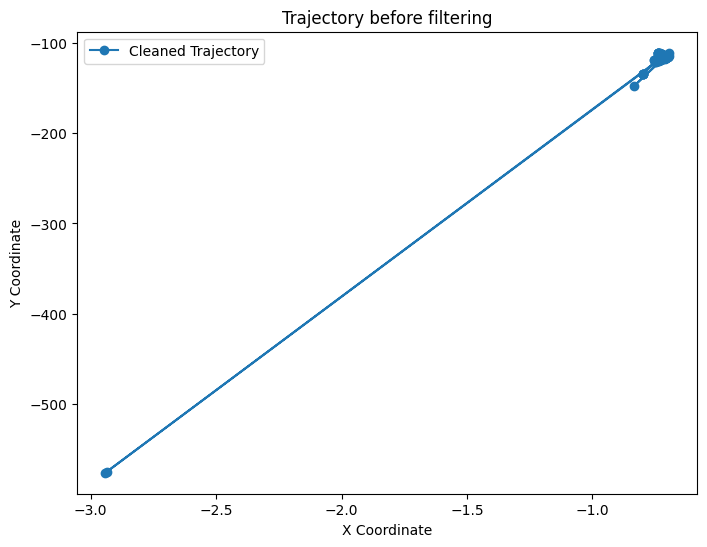

0            NaN
1       1.053762
2       1.023942
3       0.000000
4       1.030153
         ...    
126    13.214801
127     0.976077
128     0.030101
129     0.999981
130     0.970599
Name: distance, Length: 131, dtype: float64
mean: 8.201125693350997 std: 56.136469440997104


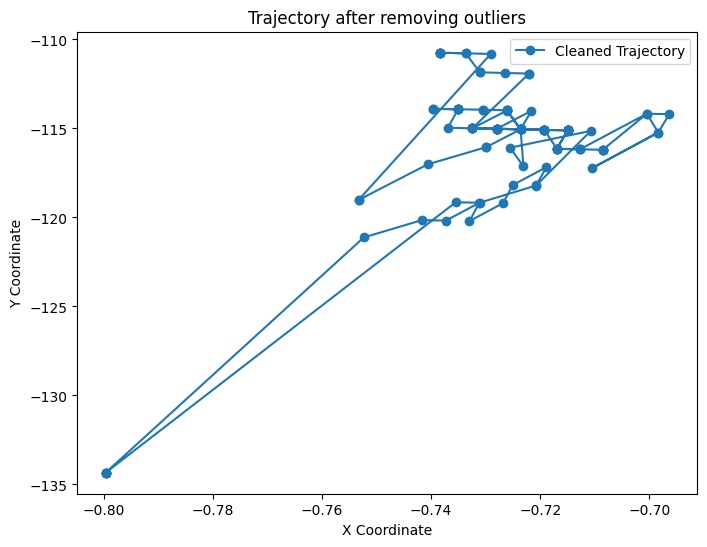

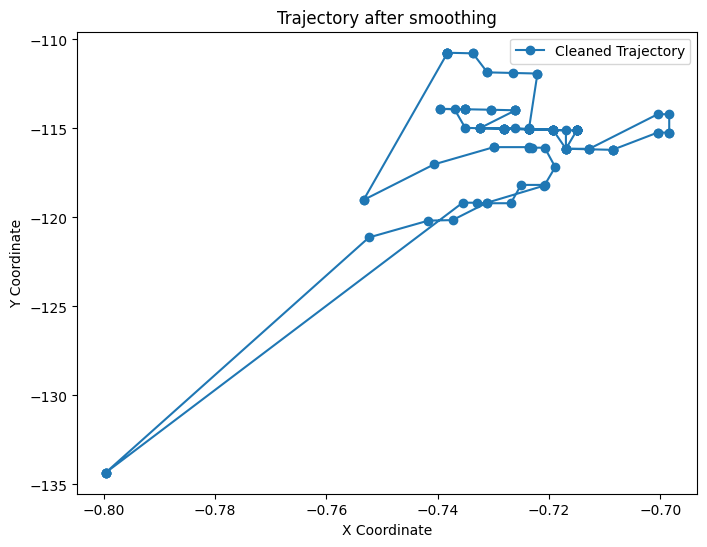

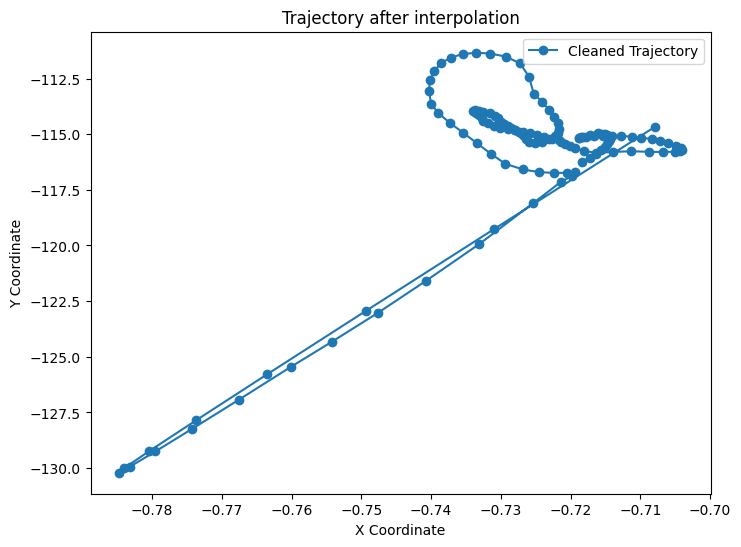

[294.0, 591.0, 691.0, 597.0]
[np.float64(-1163.2482219825451), np.float64(109.06918772744245), np.float64(1161.8114626813945), np.float64(123.43678073895151)]
[294.0, 591.0, 623.0, 120.0]
[691.0, 597.0, 786.0, 121.0]
[293.0, 592.0, 690.0, 598.0]
[np.float64(-1161.229952885551), np.float64(108.87864948584713), np.float64(1159.7954289642225), np.float64(123.22388869913023)]
[293.0, 592.0, 624.0, 119.0]
[690.0, 598.0, 785.0, 120.0]
[292.0, 592.0, 691.0, 598.0]
[np.float64(-1159.4086104345126), np.float64(108.70572252341134), np.float64(1157.9759097374751), np.float64(123.03272949378746)]
[292.0, 592.0, 624.0, 120.0]
[691.0, 598.0, 786.0, 121.0]
[292.0, 592.0, 691.0, 598.0]
[np.float64(-1157.7776104477116), np.float64(108.5498916054932), np.float64(1156.346349172607), np.float64(122.86250435653864)]
[292.0, 592.0, 624.0, 120.0]
[691.0, 598.0, 786.0, 121.0]
[293.0, 592.0, 691.0, 598.0]
[np.float64(-1156.330368743428), np.float64(108.41064149745088), np.float64(1154.900191441073), np.float64

In [697]:
# Reset the video to the beginning
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Define the codec and create a VideoWriter object to save the modified frames
output_path = project_root / "data" / f"recording_{video_number}"  / "All_Lines_video_processed.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'mp4v' codec for MP4 format
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(str(output_path), fourcc, fps, (frame_width, frame_height))

# Process the lines
upper_processed = postprocessing_upper(upper_lines)
# print('Processed lines:', upper_processed)

# initializing df
# output_df = pd.DataFrame(columns=['frame_number', 'horizontal', 'left', 'right'])

# Loop through each frame in the video
frame_index = 0
while frame_index < len(upper_processed):
    ret, video_frame = cap.read()
    if not ret:
        print("End of video or failed to read the frame at iteration", frame_index)
        break
    # print(f"Processing frame {frame_index}")

    # draw the lines on the frame   
    modified_frame = write_lines_on_frame(video_frame, [bottom_lines[frame_index], upper_processed[frame_index], left_lines[frame_index], right_lines[frame_index]])

    # add lines to the output df
    # output_df.loc[len(output_df)] = [frame_index, processed_lines[frame_index][0], processed_lines[frame_index][1], processed_lines[frame_index][2]]

    # Write the modified frame to the output video
    out.write(modified_frame)

    # Increment the frame index
    frame_index += 1

# Release the video capture and writer objects
# cap.release()
out.release()

print(f"Adjusted video saved to {output_path}")

Compute the determinant

In [698]:
def det(a, b):
    return a[0] * b[1] - a[1] * b[0]

Get the intersection of 2 lines

In [699]:
def get_intersection(line_1, line_2):
    """Find the intersection point of two lines."""
    xdiff = (line_1[0] - line_1[2], line_2[0] - line_2[2])
    ydiff = (line_1[1] - line_1[3], line_2[1] - line_2[3])

    div = det(xdiff, ydiff)
    if div == 0:
        return None

    d = (det((line_1[0], line_1[1]), (line_1[2], line_1[3])), 
           det((line_2[0], line_2[1]), (line_2[2], line_2[3])))
    x = int(det(d, xdiff) / div)
    y = int(det(d, ydiff) / div)
    return x, y

save the 4 points in a csv file

In [700]:
up_left_points = []
up_right_points = []
for i in range(len(upper_processed)):
    if upper_processed[i] is not None and left_lines[i] is not None:
        intersection = get_intersection(upper_processed[i], left_lines[i])
        if intersection is not None:
            up_left_points.append(intersection)
        else:
            up_left_points.append(None)
    else:
        up_left_points.append(None)

for i in range(len(upper_processed)):
    if upper_processed[i] is not None and right_lines[i] is not None:
        intersection = get_intersection(upper_processed[i], right_lines[i])
        if intersection is not None:
            up_right_points.append(intersection)
        else:
            up_right_points.append(None)
    else:
        up_right_points.append(None)


lane_points['up_left_x'] = [point[0] if point else np.nan for point in up_left_points]
lane_points['up_left_y'] = [point[1] if point else np.nan for point in up_left_points]
lane_points['up_right_x'] = [point[0] if point else np.nan for point in up_right_points]
lane_points['up_right_y'] = [point[1] if point else np.nan for point in up_right_points]

# Save the updated DataFrame to a new CSV file
output_csv_path = project_root / "data" / "auxiliary_data" / f"lane_points_processed_{video_number}.csv"
lane_points.to_csv(output_csv_path, index=False)
print(f"Updated lane points saved to {output_csv_path}")
# Close the video capture
cap.release()


Updated lane points saved to C:\Users\miche\OneDrive\Documenti\GitHub\bowling-analysis\data\auxiliary_data\lane_points_processed_1.csv
